#### In this notebook, the following will be executed: 
1. Get observability scores for each gene over the various optimization runs 
2. Scrape the intergenic regions of all genes that were modeled iff the region is >= 100 bp
3. Sort the genes from lowest to highest based on their score and select some from the top and bottom for sensor promoter library design
4. Add the adapter sequences to each promoter, each containing identical overhangs in case the cloning is done in pooled format
5. Query uniprot for protein function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams.update({'figure.autolayout': True})
import scipy as sp
from scipy.signal import savgol_filter as savgol
import seaborn as sb
import pandas as pd
pd.set_option('display.max_rows', 1000)
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os
import sys
from regions import get_interregions, get_promoterregions
from copy import deepcopy
from bioservices import UniProt
import time
import seaborn as sn
from compress_pickle import dump, load
import pickle

In [2]:
class Datatable:
    def __init__(self,datadict,fasta_path,genbank_path,getRecords=False):
        '''This class is an all-in-one function to 1) extract dictionary keys from run outputs 
        and 2) prepare necessary information for promoter region mining. For 2), we need both the
        cds_from_genome.fasta as well as the .gbff as datadict's IDs are only found in the fasta 
        but the fasta is extremely unparseable (too many edge cases). The genbank file comes in handy
        to extract descriptive gene info after identifying which features to keep using the fasta. '''
        
        # assign all the dictionary keys that came from the output of optimal_sensors run 
        self.X = datadict['X'] # dataset used to fit model parameters
        self.transcriptIDs = datadict['transcriptIDs'] # all transcriptIDs of original dataset
        self.keep_transcriptIDs = datadict['keep_transcriptIDs'] # transcriptIDs corresponding to used dataset
        self.A = datadict['A'] # learned model
        self.C = datadict['C'] # observer matrix
        self.seed = datadict['seed'] # random seed for optimization 
        
        if getRecords:
            # get records of the genes that we have kept for analysis
            # have to use cds_from_genome.fasta because this is the where the transcriptIDs came from (e.g. lcl|AM181176.4_cds_CAY53368.1_5775)
            self.fasta_records = list(SeqIO.parse(fasta_path,'fasta')) # full cds_from_genome fasta
            self.keep_fasta_records = [] # getting records of genes that we have used
            for tx in self.keep_transcriptIDs:
                for rec in self.fasta_records:
                    if rec.name == tx:
                        self.keep_fasta_records.append(rec)

            # match locus_tags in keep_records (from fasta) with tags in genbank to easily parse rest of cds' description 
            # can grab gene names and tags from the fasta description, other info need to grab from the genbank
            self.genes, self.locus_tags = [],[] 
            for rec in self.keep_fasta_records:
                rec_elems = [x.strip().strip(']') for x in rec.description.split(' [')]
                if 'gene=' in str(rec_elems): # sequence has gene name (e.g. gene=dnaA)
                    self.genes.append(rec_elems[1][5:])
                    self.locus_tags.append(rec_elems[2][10:])
                elif 'gene=' not in str(rec_elems): # sequence has no gene name, but has locus tag
                    self.genes.append('N/A')
                    self.locus_tags.append(rec_elems[1][10:])

            # now map the locus_tags to corresponding features in genbank, grab feature's proteins, locations, and strandedness
            gb_records = next(SeqIO.parse(genbank_path,'genbank'))
            self.proteins,self.locations = [],[] # each element of locations will be of length 3, 0:start,1:end,2:strand
            for tag in self.locus_tags:
                for feature in gb_records.features:
                    if feature.type == 'CDS':
                        if feature.qualifiers['locus_tag'][0] == tag: 
                            try:
                                self.proteins.append(feature.qualifiers['product'][0])
                            except:
                                self.proteins.append('N/A')
                            if feature.strand == 1: # 5' -> 3'
                                self.locations.append([feature.location.start.position,feature.location.end.position,1])
                            elif feature.strand == -1: # 3' -> 5' (complementary)
                                self.locations.append([feature.location.start.position,feature.location.end.position,-1])            

        # sort C in ascending order and get corresponding inds to sort other lists
        # recall that C is a 1xN dimensional vector that contains the observability score for each gene
        self.sorted_inds = self.C[:,0].argsort() # getting indices of C in ascending order
        self.sorted_C = self.C[self.sorted_inds] # sort C in ascnding order 
        self.sorted_transcriptIDs = [self.keep_transcriptIDs[i] for i in self.sorted_inds]
        if getRecords:
            self.sorted_genes = [self.genes[i] for i in self.sorted_inds]
            self.sorted_locus_tags = [self.locus_tags[i] for i in self.sorted_inds]
            self.sorted_proteins = [self.proteins[i] for i in self.sorted_inds]
            self.sorted_locations = [self.locations[i] for i in self.sorted_inds]

In [4]:
# load in the various runs of the data. 
data_path = 'data/'
results_path = 'run-outputs/X0/'
genbank_path = data_path+'GCA_000009225.1_ASM922v1_genomic.gbff'
cdsFasta_path = data_path+'GCA_000009225.1_ASM922v1_cds_from_genomic.fa'
results_paths = [results_path+file for file in os.listdir(results_path) if not file.startswith('.')]
final_paths = []
for ii,fn in enumerate(results_paths):
    if '.txt' not in fn and 'dump' in fn:
        final_paths.append(fn)
pkl = False

data = []
if pkl:
    for ii, file in enumerate(final_paths):
        if ii == 0:
            doGetRecords = True
        else: 
            doGetRecords = False
        data.append(Datatable(pickle.load(open(file,'rb')),cdsFasta_path,genbank_path,getRecords=doGetRecords))
if not pkl: # then compressed pickle
    for ii, file in enumerate(final_paths):
        if ii == 0:
            doGetRecords = True
        else: 
            doGetRecords = False
        data.append(Datatable(load(file),cdsFasta_path,genbank_path,getRecords=doGetRecords))

In [74]:
def plot_gene_traces(data,k,start='0',pltdim=(10,10),savedir='figures/',savefig=False,showfig=False):
    '''data is a Datatable object. k is the number of genes to plot and
    pltdim should be (sqrt(k),sqrt(k))'''
    
    if start=='-1':
        X = data.X[data.sorted_inds[-k:]]
        genes = data.sorted_genes[-k:]
        tags = data.sorted_locus_tags[-k:]
    else:
        X = data.X[data.sorted_inds[0:k]]
        genes = data.sorted_genes[0:k]
        tags = data.sorted_locus_tags[0:k]
    nreps = 3
    tspan = np.linspace(20,100,X.shape[1])
    fig, axs = plt.subplots(pltdim[0], pltdim[1], figsize=(12,10));
    mt =  ['o--','d--','p--']
    repname = ['R1','R2','R3']
    colors = ['tab:blue','tab:orange','tab:green']
    count = 0
    for ax in axs.reshape(-1):
        ymin,ymax = np.min(X[count])-25,np.max(X[count])+25
        for rr in range(0,nreps): 
            ax.plot(tspan,X[count,:,rr],mt[rr],lw=2,ms=5,color=colors[rr],label=repname[rr]);
            # add gene names or locus tags to subplot title
            if genes[count] == 'N/A':
                ax.set_title(tags[count],fontsize=12)
            else:
                ax.set_title(genes[count],fontsize=12)
        # Hide the right and top spines and make bottom and left axes thicker
        for axis in ['right','top']:
            ax.spines[axis].set_visible(False)
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(1.2)
        # increase ticklabel fontsizes
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_ylim([ymin,ymax])
        count+=1
        
    axs[-1,-1].legend(repname,bbox_to_anchor=(1.05, 1),loc='upper left',markerscale=2,fontsize=12,shadow=True)
    
    # Set common labels
    fig.text(0.5, -0.01, r'$Time \; (minutes)$', ha='center', va='center',fontsize=20)
    fig.text(-0.04, 0.5, r'$TPM_{BS}$', ha='center', va='center', rotation='vertical',fontsize=22)
        
    plt.tight_layout();
    if savefig:
        plt.savefig(savedir,bbox_inches='tight')
    if not showfig:
        plt.close()

def plot_eigvals(matrix):
    theta = np.linspace(0,20,100)
    L = np.linalg.eigvals(matrix)
    plt.figure();
    plt.plot(np.real(L),np.imag(L),'o');
    plt.plot(np.cos(theta),np.sin(theta),color='black',alpha=0.3)
    plt.axis('equal');

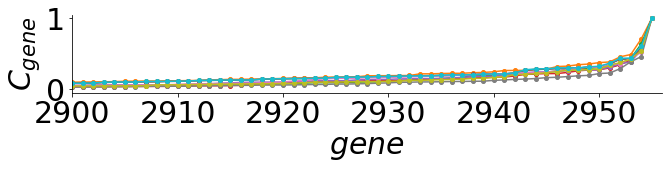

In [174]:
# plotting each observability score individually to check for consistency of the optimization routine
plt.figure(figsize=(10,3));
for ii in range(len(data)):
    plt.plot(data[ii].sorted_C,'o-',ms=4);
    plt.ylabel(r'$C_{gene}$');
    plt.xlabel(r'$gene$');
    plt.xlim(2900,len(data[ii].sorted_C))


In [7]:
# getting mean of scores and sorting in ascending order
scores = []
for ii in range(len(data)):
    scores.append(data[ii].C)
scores = np.squeeze(np.array(scores),axis=2)
mean_scores,stdev_scores = np.mean(scores,axis=0),np.std(scores,axis=0)
sorted_inds = mean_scores.argsort() 
sorted_mean_scores = mean_scores[sorted_inds] 
sorted_stdev_scores = stdev_scores[sorted_inds]
sorted_transcriptIDs = [data[0].keep_transcriptIDs[i] for i in sorted_inds]
sorted_genes = [data[0].genes[i] for i in sorted_inds]
sorted_locus_tags = [data[0].locus_tags[i] for i in sorted_inds]
sorted_proteins = [data[0].proteins[i] for i in sorted_inds]
sorted_locations = [data[0].locations[i] for i in sorted_inds]

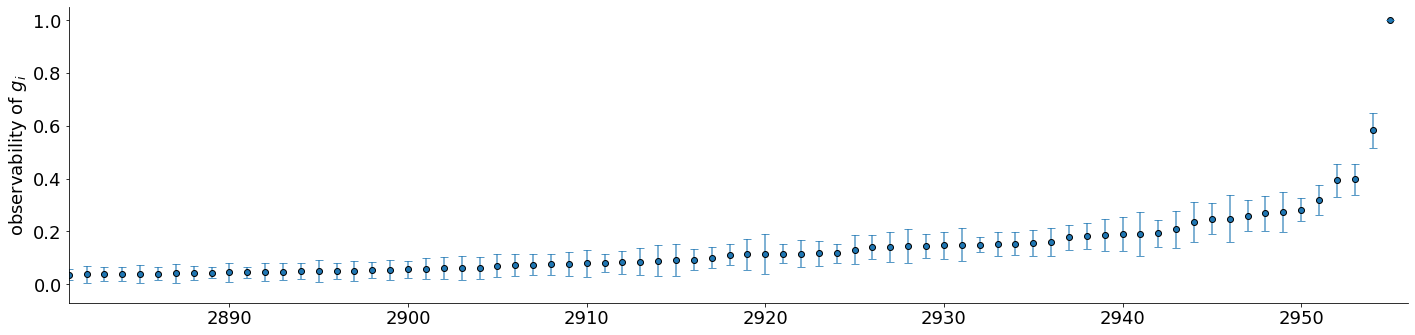

In [26]:
# visualizing the mean score with standard deviation as error bars
plt.figure(figsize=(20,5));
plt.plot(list(range(len(sorted_mean_scores))),sorted_mean_scores,'o',color='tab:blue',mec='black')
plt.errorbar(list(range(len(sorted_mean_scores))),sorted_mean_scores,yerr=sorted_stdev_scores,fmt='.',ms=0,\
             color='tab:blue',capsize=4,alpha=0.75);
# plt.xticks(ticks=list(range(len(sorted_mean_scores))),labels=sorted_genes,fontsize=14,rotation='vertical')
# plt.xlabel(r'$g_i$');
plt.ylabel(r'observability of $g_i$');
plt.xlim(len(sorted_genes)-75,len(sorted_genes));
# grids = list(np.linspace(0.0,1.0,11))
# for ii in grids:
#     plt.hlines(ii,0,700,color='tab:gray',alpha=0.3)
# plt.grid('on',axis='x')
# plt.savefig('figures/obs_scores.pdf');

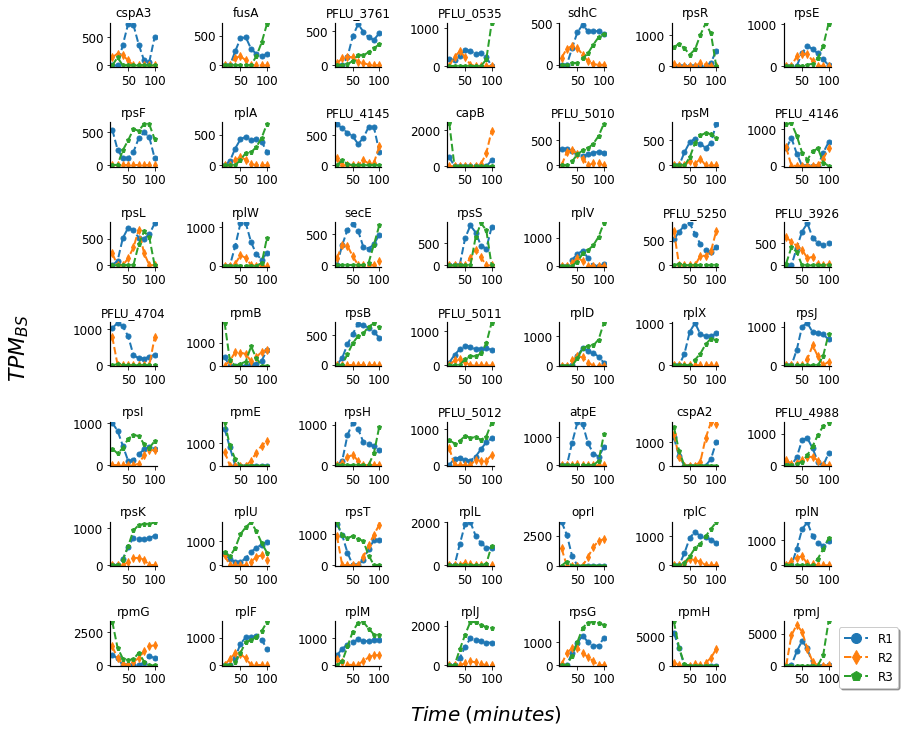

In [58]:
# plot bottom scorers or top scorers
k = 49
save_dir = 'figures/data_top50.pdf'
plot_gene_traces(data[0],k,pltdim=(7,7),start='-1',savedir=save_dir,savefig=False,showfig=True)



In [166]:
def plot_selected_gene_traces(data,selInds,savedir='figures/',savefig=False,showfig=False):
    
    # selInds is the list of indices corresponding to observability scores in ascending order 
    
    plt.rcParams.update({'font.size': 30})
    
    X = data.X[selInds]
    genes = [(data.genes)[ii] for ii in selInds]
    tags = [data.locus_tags[ii] for ii in selInds]
    nreps = 3
    tspan = np.linspace(20,100,X.shape[1])
    fig, axs = plt.subplots(7,7,figsize=(22,18));
    mt =  ['o--','d--','p--']
    repname = ['R1','R2','R3']
    colors = ['tab:blue','tab:orange','tab:green']
    count = 0
    for ax in axs.reshape(-1):
        ymin,ymax = np.min(X[count])-25,np.max(X[count])+25
        for rr in range(0,nreps): 
            ax.plot(tspan,X[count,:,rr],mt[rr],lw=3,ms=10,color=colors[rr],label=repname[rr]);
            # add gene names or locus tags to subplot title
            if genes[count] == 'N/A':
                ax.set_title(tags[count],fontsize=15,fontweight='bold')
            else:
                ax.set_title(genes[count],fontsize=15,fontweight='bold')
        # Hide the right and top spines and make bottom and left axes thicker
        for axis in ['right','top']:
            ax.spines[axis].set_visible(False)
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(1.2)
        # increase ticklabel fontsizes
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_ylim([ymin,ymax])
        count+=1
        
    axs[-1,-1].legend(repname,bbox_to_anchor=(1.05, 1),loc='upper left',markerscale=2,fontsize=15,shadow=True)
    
    # Set common labels
    fig.text(0.5, -0.01, r'$Time \; (minutes)$', ha='center', va='center',fontsize=20)
    fig.text(-0.04, 0.5, r'$TPM_{BS}$', ha='center', va='center', rotation='vertical',fontsize=22)
        
    plt.tight_layout();
    if savefig:
        plt.savefig(savedir,bbox_inches='tight')
    if not showfig:
        plt.close()

kk = 2
plot_selected_gene_traces(data[0],sorted_inds[-49:],savedir='figures/3rd49.pdf',savefig=False,showfig=True)

In [ ]:
def plot_selected_sorted_gene_traces(dataX,sorted_scores,keepers,data,savedir='figures/',savefig=False,showfig=False):
    
    # selInds is the list of indices corresponding to observability scores in ascending order 
    
    plt.rcParams.update({'font.size': 30})
    
    X = dataX
    genes = [(data.genes)[ii] for ii in sorted_scores[-49:]]
    genes = [genes[ii] for ii in keepers]
    tags = [data.locus_tags[ii] for ii in sorted_scores[-49:]]
    tags = [tags[ii] for ii in keepers]
    nreps = 3
    tspan = np.linspace(20,100,X.shape[1])
    fig, axs = plt.subplots(7,7,figsize=(22,18));
    mt =  ['o--','d--','p--']
    repname = ['R1','R2','R3']
    colors = ['tab:blue','tab:orange','tab:green']
    count = 0
    for ax in axs.reshape(-1):
        ymin,ymax = np.min(X[count])-25,np.max(X[count])+25
        for rr in range(0,nreps): 
            ax.plot(tspan,X[count,:,rr],mt[rr],lw=3,ms=10,color=colors[rr],label=repname[rr]);
            # add gene names or locus tags to subplot title
            if genes[count] == 'N/A':
                ax.set_title(tags[count],fontsize=15,fontweight='bold')
            else:
                ax.set_title(genes[count],fontsize=15,fontweight='bold')
        # Hide the right and top spines and make bottom and left axes thicker
        for axis in ['right','top']:
            ax.spines[axis].set_visible(False)
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(1.2)
        # increase ticklabel fontsizes
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_ylim([ymin,ymax])
        count+=1
        
    axs[-1,-1].legend(repname,bbox_to_anchor=(1.05, 1),loc='upper left',markerscale=2,fontsize=15,shadow=True)
    
    # Set common labels
    fig.text(0.5, -0.01, r'$Time \; (minutes)$', ha='center', va='center',fontsize=20)
    fig.text(-0.04, 0.5, r'$TPM_{BS}$', ha='center', va='center', rotation='vertical',fontsize=22)
        
    plt.tight_layout();
    if savefig:
        plt.savefig(savedir,bbox_inches='tight')
    if not showfig:
        plt.close()
        

#### Compute the scores based on C * X, the flux

In [127]:
CXscores = np.zeros((len(data[0].C),data[0].X.shape[2]*len(data)))
count = 0
for ii in range(len(data)): # number of optimization runs
    for jj in range(data[0].X.shape[2]): # number of replicates
        CXscores[:,count] = (np.linalg.norm((data[ii].C * data[ii].X[:,:,jj]),ord=2,axis=1)) # comment me please
        count += 1
        
mean_CXscores = np.mean(CXscores,axis=1)
stdev_scores = np.std(CXscores,axis=1)
sorted_CXscores_inds = mean_CXscores.argsort()

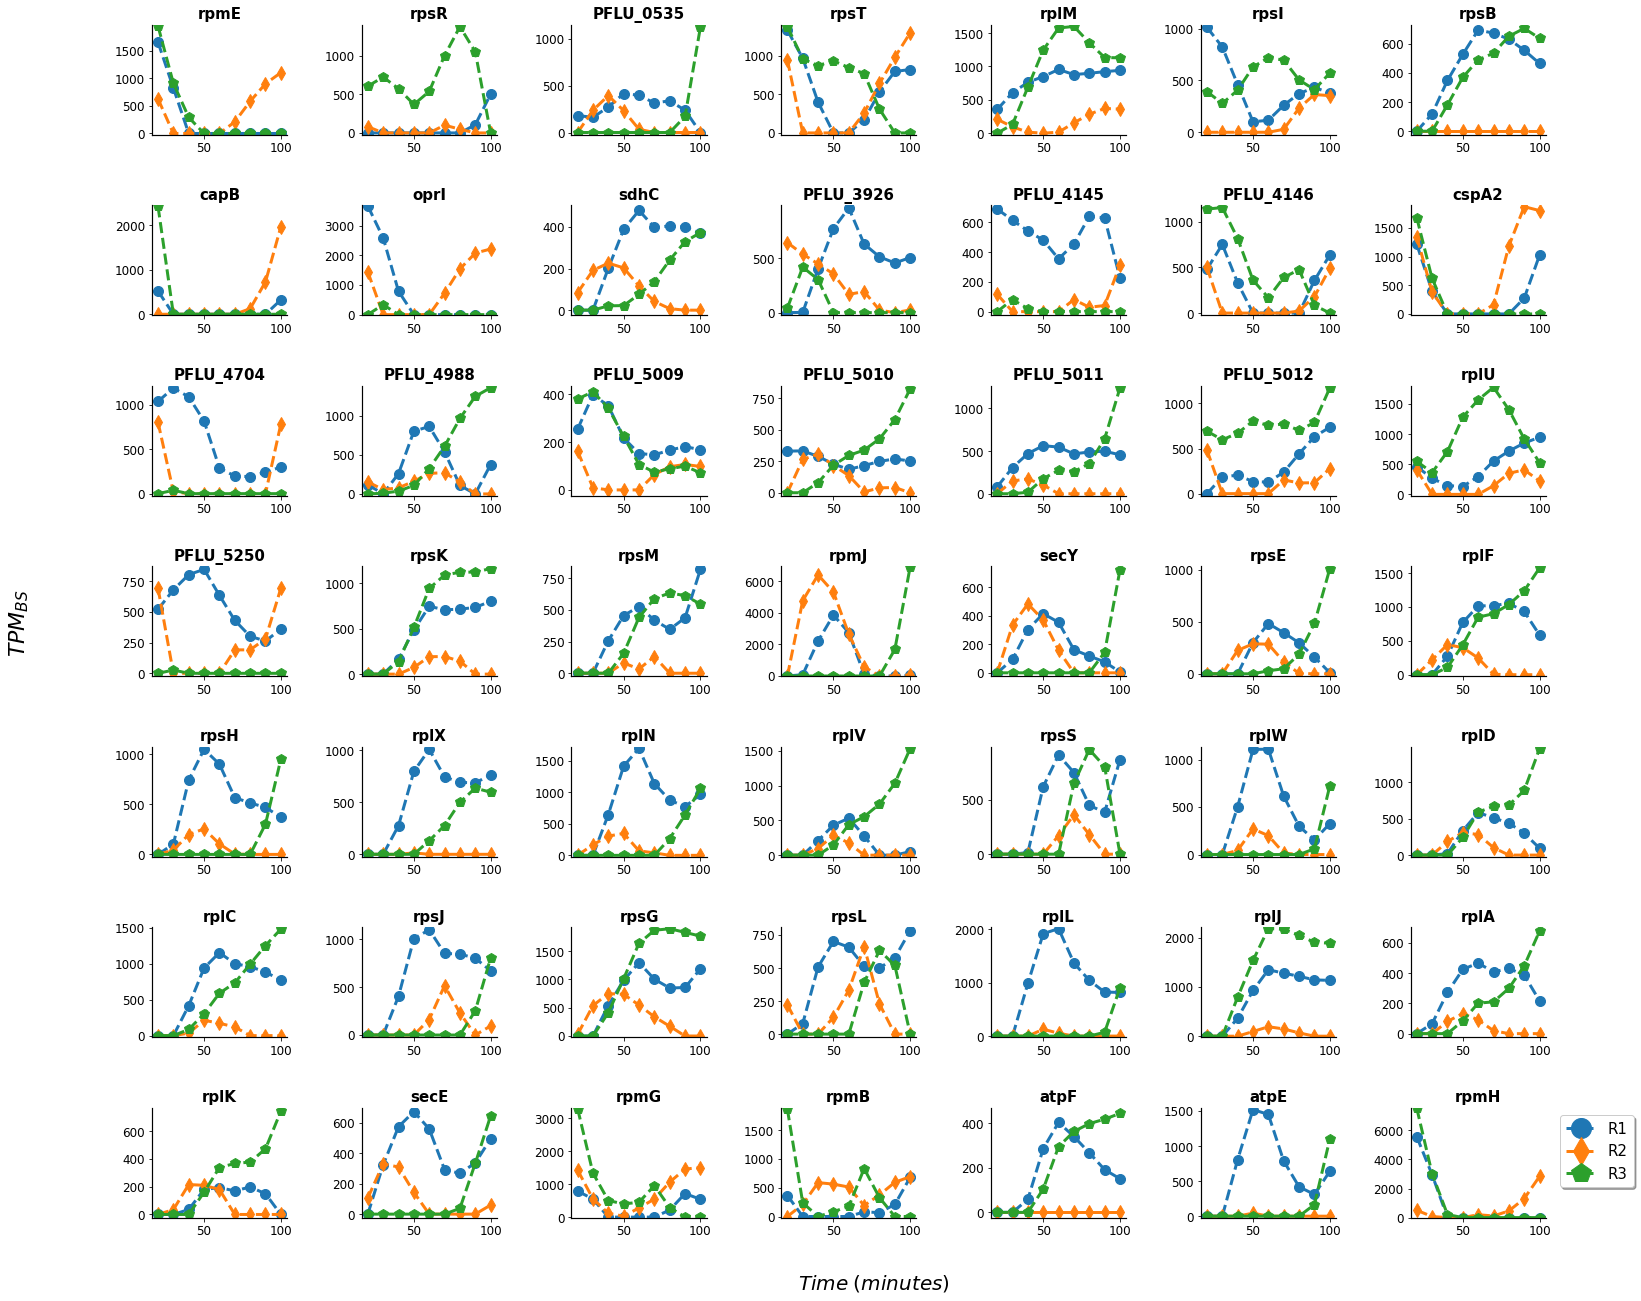

In [172]:
# create some order so easy to see the differences between output flux maximization and output influence maximization
# testarr = np.array([data[0].locus_tags[ii] for ii in sorted_CXscores_inds[-49:]])
# keepinds = testarr.argsort()
# plot_selected_sorted_gene_traces((data[0].X[sorted_CXscores_inds[-49:]])[keepinds],sorted_CXscores_inds,keepinds,data[0],\
#                           savedir='figures/1st49_CX.pdf',savefig=True,showfig=True)
# testarr = np.array([data[0].locus_tags[ii] for ii in sorted_inds[-49:]])
# keepinds = testarr.argsort()
# plot_selected_sorted_gene_traces((data[0].X[sorted_inds[-49:]])[keepinds],sorted_inds,keepinds,data[0],\
#                           savedir='figures/1st49.pdf',savefig=True,showfig=True)

#### Compare to left eigenvector approach for observability maximization

PFLU_5598


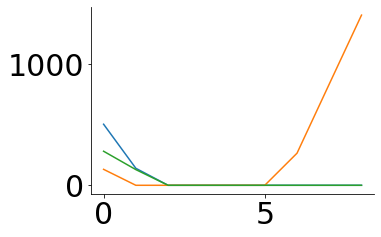

In [122]:
# left eigenvectors of matrix are given by right eigenvectors of transposed matrix
# or we can just use scipy.linalg.eig
llam, lvec = sp.linalg.eig(data[0].A,left=True,right=False)

# Grab the left eigenvector corresponding to largest eigenvalue
idx = np.argmax(np.absolute(llam))
maxlvec = np.expand_dims(np.absolute(lvec[:,idx].T),axis=1)

k = np.argmax(maxlvec)
for ii in range(3):
    plt.plot(data[0].X[k,:,ii])
print(data[0].locus_tags[k])

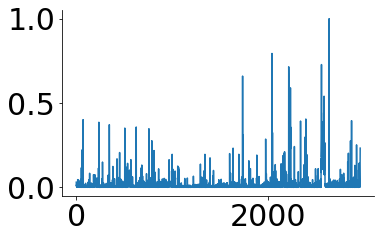

In [123]:
maxlvec = maxlvec/np.max(maxlvec);
testvec = list(maxlvec)
# testvec.sort()
plt.plot(testvec);

0.06751907491638598

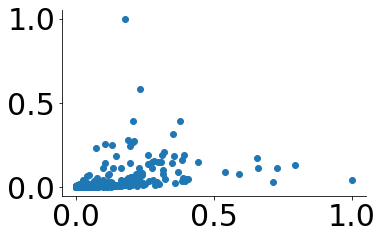

In [125]:
plt.scatter(testvec,mean_scores);
np.linalg.norm(np.array(testvec) - np.array(mean_scores))/(len(testvec))

#### Get the intergenic regions (or putative promoter regions) from the genbank (gbff) file

In [ ]:
intergenic_records = get_interregions(genbank_path,intergene_length=100)
# Q: What should be the minimum intergene_length? 

doWrite = False
if doWrite:
    outpath = os.path.splitext(os.path.basename(genbank_path))[0] + "_ign.fa"
    SeqIO.write(intergenic_records, open('data/'+outpath, 'w'), 'fasta');

#### Given the gene's location, output the nearest promoter region. 

In [ ]:
# get promoter sequences (intergenic regions) for all the genes modeled
promoter_records = get_promoterregions(data[0],intergenic_records,genbank_path,rel_dist_thresh=5000)

doWrite = False
if doWrite:
    outpath = os.path.splitext(os.path.basename(genbank_path))[0] + "_promoters.fa"
    SeqIO.write(promoter_records, open('data/'+outpath, 'w'), 'fasta');

In [ ]:
# plotting all putative promoter lengths
promoters = []
for record in promoter_records: 
    promoters.append(str(record.seq))
promoters = [promoters[i] for i in sorted_inds]
promoter_lens = [len(i) for i in promoters]
promoter_lens.sort()
plt.figure();
plt.plot(promoter_lens,'o',mec='black');
# plt.hlines(300,-10,600,color='red');
# plt.xlim(-10,len(promoter_lens)+10);
plt.xlabel(r'$\mathcal{P}_i$');
plt.ylabel(r'length in bp of $\mathcal{P}_i$');

#### Get promoter sequences and gene identity of top 20 or so (10 ribosomal protein coding genes and 10 other) and bottom 20 genes. 


In [ ]:
# make a dataframe object which has the gene metadata
metadf = pd.DataFrame([sorted_locus_tags,sorted_genes,sorted_proteins,sorted_locations,\
        list(sorted_mean_scores),promoters]).T
metadf.columns = ['locus_tag','gene','protein','location','observability_score','promoter_sequence']
metadf

In [ ]:
# grab top 20 (10 riboProtein, 10 not)
# grabbing them manually while ensuring they are unique sequences
top = [505,504,503,502,501,500,499,498,497,495,493,488,485,481,480,479,470,466,462,461] # 4 to go
# grab bottom 20 
bottom = [0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20] # excluded 8 because sequence was duplicated
bottom.reverse()
selected = top+bottom

#### Write a fasta that contains the promoter sequences for the selected promoters 

In [ ]:
# getting all promoter sequences that were selected into a dataframe and SeqRecord.
selmetadf = metadf.loc[selected].reset_index()
selected_promoters = []
for ii,tag in enumerate(selmetadf.locus_tag):
    for record in promoter_records:
        if tag in record.id:
            selected_promoters.append(SeqRecord(record.seq,id="%s_%s"%(tag,'promoter'),\
                description="%d-%d-%s%d"%(selmetadf.location[ii][0],\
                                        selmetadf.location[ii][1],\
                                        'strand',selmetadf.location[ii][2])))

In [ ]:
selmetadf

In [ ]:
# count number of unique promoter sequences
selected_promoter_seqs = []
for record in selected_promoters:
    selected_promoter_seqs.append(str(record.seq))

print('unique promoter sequences', len(set(selected_promoter_seqs)),'out of total genes selected',len(selected_promoter_seqs))

In [ ]:
# write all selected promoters to fasta
unique_selected_promoters = []
for ii in range(len(selmetadf)):
    unique_selected_promoters.append(SeqRecord(Seq(selmetadf.promoter_sequence[ii]),\
                                id="%s"%(selmetadf.locus_tag[ii]),\
                                description="%s, %s"%(selmetadf.location[ii],\
                                selmetadf.observability_score[ii])))
    
doWrite = False
if doWrite:
    outpath = os.path.splitext(os.path.basename(genbank_path))[0] + "_selected_promoters.fa"
    SeqIO.write(unique_selected_promoters, open('data/'+outpath, 'w'), 'fasta');

In [ ]:
# length of each selected promoter sequence plotted
selected_promoter_lens = [len(i) for i in selmetadf.promoter_sequence]
plt.figure(figsize=(12,4));
plt.bar(list(range(len(selected_promoter_lens))),selected_promoter_lens,edgecolor='black');
plt.xticks(ticks=list(range(len(selected_promoter_lens))),labels=selmetadf.gene,fontsize=16,rotation='vertical')
plt.xlabel(r'$\mathcal{P}_i$');
plt.ylabel(r'length in bp of $\mathcal{P}_i$');
plt.tight_layout();
# plt.savefig('figures/selected_promoter_lengths.pdf')

#### Prep the selected sequences for golden gate assembly and pcr amplification

In [ ]:
# add overhang sequences to 5' and 3' ends of each promoter
# Golden Gate design spreadsheet
# https://docs.google.com/spreadsheets/d/17Im8nkrhQNl_yyJ2wWQyaKKL3IpOIfpZhuRFKMVX4Nk/edit#gid=1116264433
# realizing it might be faster to just do it in Geneious. If there were more sequences, it wouldn't be faster. 

#### Query uniprot with species id and locus tag 

In [ ]:
def query_uniprot(taxonomy='SBW25',all_tags_list=['PFLU_5352'],query_length=100,search_columns='genes,protein names,comment(FUNCTION)'):
    start_time = time.time()
    df_up = pd.DataFrame()
    up = UniProt()
    if len(all_tags_list)>query_length:
        tag_lists = [all_tags_list[i:i+query_length] for i in range(0,len(all_tags_list),query_length)]
    else:
        tag_lists = all_tags_list   
    for ii in range(len(tag_lists)):
        query_search = '\"' + taxonomy + '\" AND ('
        for locus_tag in tag_lists[ii][0:-1]:
            query_search = query_search + '\"' + locus_tag + '\" OR '
        query_search = query_search + '\"' + sorted_locus_tags[-1] + '\")'
        search_result = up.search(query_search, frmt='tab',columns=search_columns)
        str_up_ALL = search_result.split('\n')
        ls_up = []
        for each_line in str_up_ALL[1:]:
            ls_up.append(each_line.split('\t'))
        df_ii_up = pd.DataFrame(ls_up[0:-1])
        df_up = df_up.append(df_ii_up)
    df_up.columns = str_up_ALL[0].split('\t')
    df_up.rename(columns={'Gene names':'gene','Function [CC]':'function','Protein names':'protein'},inplace=True)
    df_up.reset_index(inplace=True)
    df_up.drop(columns=['index'],inplace=True)
    print((time.time() - start_time)/60,'minutes')
    return df_up

In [ ]:
df_up = query_uniprot(all_tags_list=sorted_locus_tags[-1000:-1])

In [ ]:
df_up

In [ ]:
metadf['function'] = np.nan
function = []
for ii,tag in enumerate(metadf.locus_tag):
    for jj,query_tag in enumerate(df_up.gene):
        if tag in query_tag:
            metadf.iloc[ii,-1] = df_up.function[jj]
    if metadf.iloc[ii,-1] == '':
        metadf.iloc[ii,-1] = metadf.iloc[ii,2]

In [ ]:
metadf.observability_score = np.round(np.array(metadf.observability_score,dtype=np.float),4)

In [ ]:
# output the functionality as a table along with the gene or locus_tag and observability score
(metadf[['locus_tag','gene','observability_score','function']].iloc[len(metadf)-50:]).to_csv('test.csv',sep=',',index=False)

In [ ]:
for ii,tag in enumerate(df_up.gene):
    if 'atpE' in tag:
        print(df_up.function[ii])

In [ ]:
data[0].keep_transcriptIDs.index('lcl|AM181176.4_cds_CAY47109.1_821')

In [184]:
tp_list = [2,3,4,5,6,7]

In [185]:
data[0].X[:,tp_list,:]

array([[[0.00000000e+00, 2.97230238e+01, 2.16764286e+01],
        [5.19600000e+00, 2.37155714e+01, 3.67749048e+01],
        [2.20328571e+01, 1.90801905e+01, 4.99609524e+01],
        [1.70016667e+01, 9.78638095e+00, 5.23876667e+01],
        [8.05297619e+00, 6.84916667e+00, 4.49449048e+01],
        [4.11183333e+00, 3.36395238e+00, 3.76006905e+01]],

       [[0.00000000e+00, 1.82416667e+00, 5.56611905e+00],
        [0.00000000e+00, 0.00000000e+00, 1.87309524e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.43714286e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.11038095e+00, 0.00000000e+00, 0.00000000e+00],
        [5.35314286e+00, 0.00000000e+00, 0.00000000e+00],
        [1.31779048e+01, 0.00000000e+00, 0.00000000e+00],
        [2.09369762e+01, 4.49000000e-01, 0.00000000e+00],
        [1